In [1]:
from cosapp.drivers import RungeKutta
from cosapp.recorders import DataFrameRecorder
from cosapp.drivers import NonLinearSolver, RunOnce, MonteCarlo, RunSingleCase
from cosapp.utils.distributions import Normal
import sys
sys.path.append('./model')
from Earth import Earth
import json
import numpy as np

earth = Earth("earth")

l = 2 #Rocket's length on the plot
dt = 0.05 #Time-step


from cosapp.utils.distributions import Normal
from cosapp.drivers import MonteCarlo
from cosapp.recorders import DataFrameRecorder

In [2]:

#Initial conditions and constants

rocketNum = 2622
l = 0.855
angz = -np.deg2rad(85)
expCoef = False #True for experimental drag coefficient, false for analytical (possibly innacurate)
Wind = False #True for wind effects, false for no wind
Lift = True #True for lift effects (trajecto does not consider them), false for no lift

init = {
    'Traj.r' : np.array([-(l/2)*np.sin(angz), 0., (l/2)*np.cos(angz)]),
    'Para.DynPar.r1' : np.array([0., 0., l/2]),
    'Para.DynPar.r2' : np.array([0., 0., l/2]),
    'Rocket.Kin.ar' : np.array([0, angz, 0]),
    'Rocket.CG' : l/2,
    
    'Rocket.Mass.m' : 2.0783,
    'Rocket.Mass.m0' : 2.0783,
    'Rocket.Mass.Dm' : 0.076,
    'Rocket.Mass.lastEngineTime' : 1.,
    'Rocket.Mass.I0_geom' : 1*np.array([1., 100., 100.]),

    'Rocket.Kin.v' : np.array([0,0,0]),
    'Rocket.Kin.av' : np.zeros(3),
    'Para.DynPar.v1' : np.array([0,0,0]),
    'Para.DynPar.v2' : np.array([0,0,0]),
    'Traj.ParaDepStatus': False,

    'Rocket.Aero.Coefs.ln' : 0.159,
    'Rocket.Aero.Coefs.d' : 0.08,
    'Rocket.Aero.Coefs.NFins' : 4,
    # 'Rocket.Aero.Coefs.s' : 0.13,
    'Rocket.Aero.Coefs.Xt' : 0.09,
    'Rocket.Aero.Coefs.Cr' : 0.145,
    'Rocket.Aero.Coefs.Ct' : 0.09,
    # 'Rocket.Aero.Coefs.tf' : 0.002,
    # 'Rocket.Aero.Coefs.delta' : 0.,

    'Rocket.Aero.Coefs.TypeCd' : expCoef,
    'Wind.wind_on' : Wind,
    'Rocket.Aero.Aeroforces.isLift': Lift,
    'Rocket.Aero.Coefs.Cd_exp': 0.6,

    'Traj.parachute_deploy_method' : 0,
    'Traj.parachute_deploy_timer' : 0.,

}

In [ ]:
driver = earth.add_driver(RungeKutta(order=4, dt=dt))
driver.add_recorder(DataFrameRecorder(includes=['Rocket.Kin.ar', 'Traj.r', 'Rocket.Kin.v', 'Para.DynPar.r2']), period=0.1)
driver.add_child(NonLinearSolver('solver', factor=1.0))
driver.time_interval = (0, 70)

# Define a simulation scenario
driver.set_scenario(
    init = init,
    stop = 'Para.DynPar.r2[2] < -1'
)

earth.run_drivers()


In [3]:
def run_analysis(syst, draws=10, linear=True):
    syst.drivers.clear()  # Remove all drivers on the System

    # runonce = syst.add_driver(RunOnce("runonce"))
    driver = syst.add_driver(RungeKutta(order=4, dt=dt))
    # driver.add_recorder(DataFrameRecorder(includes=['Rocket.Kin.ar', 'Traj.r', 'Rocket.Kin.v', 'initrot', 'Rocket.Thrust.inclinaison']), period=0.1)
    driver.add_child(NonLinearSolver('solver', factor=1.0))
    driver.time_interval = (0, 70)

    # Define a simulation scenario
    driver.set_scenario(
        init = init,
        stop = 'Para.DynPar.r2[2] < -1'
    )

    syst.run_drivers()

    print("MONTECARLO")
    # Montecarlo
    syst.drivers.clear()
    montecarlo = syst.add_driver(MonteCarlo('mc'))
    montecarlo.add_recorder(DataFrameRecorder(includes=['Para.DynPar.r2', 'Para.DynPar.v2', 'Rocket.Aero.Coefs.delta']))
    # montecarlo.add_child(runonce)
    montecarlo.add_child(driver)
    montecarlo.draws = draws
    # montecarlo.linear = linear

    # parameters for uncertainties in the data
    # pitch_attr = syst.inwards.get_details('pitch_init')
    # yaw_attr = syst.inwards.get_details('yaw_init')
    # montecarlo_coef_attr = syst.Rocket.Aero.Coefs.inwards.get_details('montecarlo_coef')
    delta_attr = syst.Rocket.Aero.Coefs.inwards.get_details('delta')
    # s_attr = syst.Rocket.Aero.Coefs.inwards.get_details('s')
    # tf_attr = syst.Rocket.Aero.Coefs.inwards.get_details('tf')
    
    # Set the distribution around the current value
    # pitch_attr.distribution = Normal(best=.1, worst=-.1, pbest=0.000001, pworst=0.000001)
    # yaw_attr.distribution = Normal(best=.4, worst=-.4, pbest=0.00001, pworst=0.000001)
    # montecarlo_coef_attr.distribution = Normal(best=.3, worst=-.3, pbest=0.01, pworst=0.01)
    delta_attr.distribution = Normal(best=.1, worst=-.1, pbest=0.01, pworst=0.01)
    # s_attr.distribution = Normal(best=.01, worst=-.01)
    # tf_attr.distribution = Normal(best=.001, worst=-.001)

    # montecarlo.add_random_variable('pitch_init')
    # montecarlo.add_random_variable('yaw_init')
    # montecarlo.add_random_variable('Rocket.Aero.Coefs.montecarlo_coef')
    montecarlo.add_random_variable('Rocket.Aero.Coefs.delta')
    # montecarlo.add_random_variable('Rocket.Aero.Coefs.s')
    # montecarlo.add_random_variable('Rocket.Aero.Coefs.tf')

    # Computation
    syst.run_drivers()

    return montecarlo.recorder.export_data()

In [4]:
results = run_analysis(earth, draws=100, linear=False)

___PARACHUTE DEPLOYMENT___


Rocket X Coordinate at Deployment:  13.835679460040469 m
Rocket Y Coordinate at Deployment:  13.409806230040468 m
Rocket Z Coordinate at Deployment:  171.61609847820887 m


___PARACHUTE DEPLOYMENT___


Parachute fully deployed !
MONTECARLO
___PARACHUTE DEPLOYMENT___


Rocket X Coordinate at Deployment:  13.83567946004044 m
Rocket Y Coordinate at Deployment:  13.40980623004044 m
Rocket Z Coordinate at Deployment:  171.61609847820887 m


___PARACHUTE DEPLOYMENT___


Parachute fully deployed !
___PARACHUTE DEPLOYMENT___


Rocket X Coordinate at Deployment:  13.835679460040458 m
Rocket Y Coordinate at Deployment:  13.409806230040457 m
Rocket Z Coordinate at Deployment:  171.61609847820887 m


___PARACHUTE DEPLOYMENT___


Parachute fully deployed !
___PARACHUTE DEPLOYMENT___


Rocket X Coordinate at Deployment:  13.83567946004044 m
Rocket Y Coordinate at Deployment:  13.40980623004044 m
Rocket Z Coordinate at Deployment:  171.61609847820887 m


___PARACHUTE DEPL

In [12]:
results['Para.DynPar.r2'].tolist()

[array([15.11176357, 14.68589034, -1.        ]),
 array([15.15593744, 15.68636372, -1.        ]),
 array([16.11223695, 14.73006421, -1.        ]),
 array([15.30600958, 14.86192333, -1.        ]),
 array([13.81665386, 16.51824205, -1.        ]),
 array([15.28779656, 14.88013635, -1.        ]),
 array([16.94411528, 13.39078063, -1.        ]),
 array([16.61881907, 14.26904118, -1.        ]),
 array([15.31281439, 15.21693529, -1.        ]),
 array([12.55096732, 16.16426902, -1.        ]),
 array([15.13263815, 14.76427182, -1.        ]),
 array([15.64280852, 14.88694116, -1.        ]),
 array([14.69491441, 16.19294584, -1.        ]),
 array([15.19014505, 14.70676492, -1.        ]),
 array([16.59014225, 12.12509409, -1.        ]),
 array([16.90215509, 12.7869869 , -1.        ]),
 array([15.24190188, 14.7728741 , -1.        ]),
 array([14.31280634, 16.39983394, -1.        ]),
 array([15.45469609, 14.89000532, -1.        ]),
 array([15.10538251, 14.71749951, -1.        ]),
 array([12.01982234,

In [ ]:
with open('result.txt', 'a') as fp:
    fp.write(results.to_csv())

In [ ]:
traj = np.asarray(results['Para.DynPar.r2'].tolist())
traj

array([[30.66956462, 31.5837934 , -1.        ],
       [36.75874892, 33.66192135, -1.        ],
       [24.90041063, 28.82884075, -1.        ],
       ...,
       [38.7606353 , 34.23782846, -1.        ],
       [26.46985784, 29.70019347, -1.        ],
       [33.59897662, 26.40896023, -1.        ]])

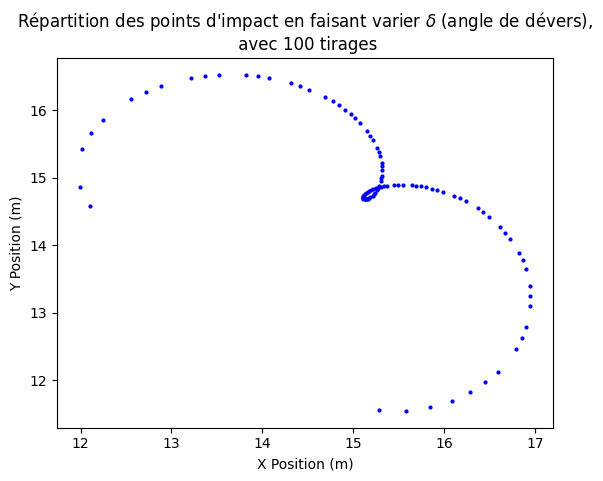

In [23]:
import numpy as np
import matplotlib.pyplot as plt

traj = np.asarray(results['Para.DynPar.r2'].tolist())

# Create the scatter plot
plt.scatter(traj[:, 0], traj[:, 1], s=4, color='blue')

# Set the title and axis labels
plt.title("Répartition des points d'impact en faisant varier $\delta$ (angle de dévers),\n avec 100 tirages")
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')

# Show the plot
plt.show()